                                             MVA - MCMC
                                             TP4 - Metropolis-Hastings within Gibbs sampler
                                        Achari Berrada Youssef 

# Exercise 1: Metropolis-Hastings within Gibbs sampler

In [117]:
import numpy as np 
%matplotlib inline 
import matplotlib.pyplot as plt 
from itertools import compress 
from statsmodels.tsa.stattools import acf
import re 
from scipy.stats import multivariate_normal as mn 
import pandas as pd

#### Target distribution $\pi$ on $\mathbb{R}^2$: 
$$ \pi(x,y) \sim \exp \left( -\frac{x^2}{a^2} - y^2 - \frac{1}{4} \left( \frac{x^2}{a^2} - y^2 \right)^2 \right) $$ 

In [7]:
# Define the function pi 
def f_pi (x,y,a) : 
    # Evaluation of pi in x,y with parameter a : 
    return np.exp( - np.power((x / a),2) - np.power(y,2) - 1/4 * np.power(np.power((x/a),2)-np.power(y,2),2) )

In [8]:
## Define the meshgrid 
xlist = np.linspace(-16,16,1000)
ylist = np.linspace(-2,2,1000)
X,Y = np.meshgrid(xlist, ylist)
## Define the levels 
a = 10
levels = np.arange(0,1,0.1)
## Plot Target distribution 
Z = f_pi(X,Y,a)

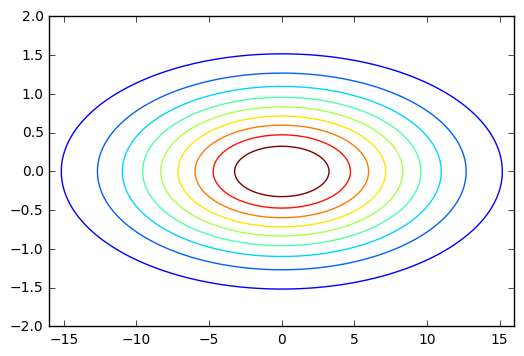

In [9]:
plt.contour(X,Y,Z,levels); 

#### Markov Transition Kernel for each component : 
Update with a symmetric random walk proposal, with a Gaussian distribution with variance $\sigma_i$

In [10]:
# Kernel P_1 
def kernel_p1(x,y,sigma_1,a): 
    # rejection counter 
    c = 0 
    # Proposal :  
    eps = np.random.randn()
    x_  = x + sigma_1 * eps 
    # Ratio :
    alpha = np.min( [1, f_pi(x_,y,a) / f_pi(x,y,a) ]) 
    # Sample uniform 
    u = np.random.uniform(0,1)
    if alpha > u  : # We accept 
        return x_,y ,c
    else : # We reject 
        c = 1 
        return x,y , c
    

In [11]:
kernel_p1(2,20,3,10)

(-2.6925246527194906, 20, 0)

In [12]:
# Kernel P_2 
def kernel_p2(x,y,sigma_2,a): 
    # rejection counter 
    c = 0 
    # Proposal :  
    eps = np.random.randn()
    y_  = y + sigma_2 * eps 
    # Ratio :
    alpha = np.min( [1, f_pi(x,y_,a) / f_pi(x,y,a) ] ) 
    # Sample uniform 
    u = np.random.uniform(0,1)
    if alpha > u  : # We accept 
        return x,y_ ,c
    else : # We reject
        c = 1
        return x,y  , c


In [13]:
# Kernel P 
def kernel_p(x,y,sigma_1,sigma_2,a) : 
    # Kernel chosen 
    kernel = 0
    # reject counter 
    reject = list([0]*2)
    if np.random.uniform(0,1) < 0.5 :
        x_,y_,c = kernel_p1(x,y,sigma_1,a)
        kernel = 1
        reject[0] = c 
        return list([x_,y_]) , reject , kernel
    else : 
        x_,y_,c = kernel_p2(x,y,sigma_2,a)
        kernel = 2
        reject[1] = c 
        return list([x_,y_]) ,reject, kernel

In [14]:
## Test P 
l,reject,kernel = kernel_p(2,2,3,3,10)

# Gibbs sampler  Start : 

In [15]:
# Parameters : 
maxIter = 5000
# You may replace sigma_i values to adapt the algorithm and start it from here : 
sigma_1 = 3 # replace by 10
sigma_2 = 3 # replace by 1 
a = 10
# Initial point 
x_0 = 6
y_0 = 5 

In [16]:
Z_sample = np.zeros((maxIter+1,2))
rej = np.zeros((maxIter,2),dtype=float)
kernels = np.zeros((maxIter,1))
Z_sample[0,:] = [x_0,y_0]

In [17]:
for i in range(maxIter): 
    l,reject,kernel = kernel_p(Z_sample[i,0],Z_sample[i,1],sigma_1,sigma_2,a)
    Z_sample[i+1,:] = l 
    rej[i,:] = reject
    kernels[i] = kernel

### Statistics 

In [18]:
N1 = np.sum(kernels==1) # Times we sample from 1
N2 = np.sum(kernels==2) # Times we sample from 2 

In [19]:
print "We have sampled form kernel 1 : {0} times".format(N1)
print "We have sampled form kernel 2 : {0} times".format(N2) 
assert N1 + N2 == maxIter

We have sampled form kernel 1 : 2515 times
We have sampled form kernel 2 : 2485 times


In [20]:
## Indices to see where we sample from at each iteration 
ind1 = list(compress(xrange(maxIter),kernels==1))
ind2 = list(compress(xrange(maxIter),kernels==2))

In [21]:
## Rejection times in kernel 1 and 2 
rej1 = np.cumsum(rej[ind1,0])
rej2 = np.cumsum(rej[ind2,1])

In [22]:
print "We have rejected form kernel 1 : {0} times".format(int(rej1[-1]))
print "We have rejected form kernel 2 : {0} times".format(int(rej2[-1]))

We have rejected form kernel 1 : 337 times
We have rejected form kernel 2 : 1761 times


In [23]:
## Iteration for each kernel 
steps1 = np.cumsum(np.ones((N1,1),dtype=float))
steps2 = np.cumsum(np.ones((N2,1),dtype=float))

In [24]:
## Acceptance times in kernel 1 and 2 
acc1 = steps1 - rej1
acc2 = steps2 - rej2

In [25]:
ratio1 = np.divide(acc1,steps1)
ratio2 = np.divide(acc2,steps2)

### Plot the acceptance rate 

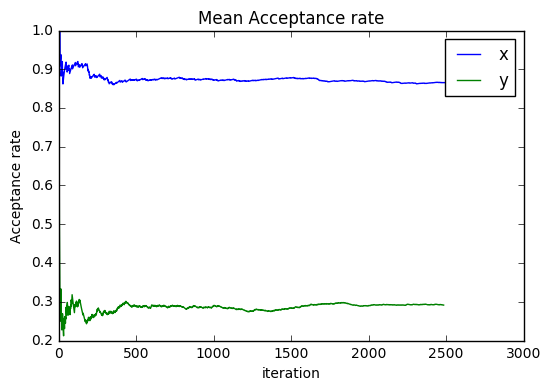

In [26]:
plotx, = plt.plot(ratio1 )
ploty, = plt.plot(ratio2 )
plt.legend([plotx,ploty],['x','y'])
plt.title('Mean Acceptance rate')
plt.xlabel('iteration')
plt.ylabel('Acceptance rate')

### Contour plot : 

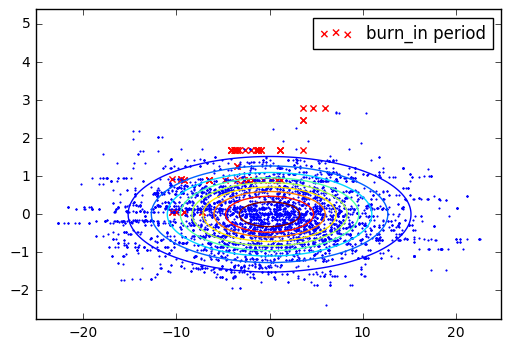

In [27]:
burn_in = 60 # Burn-in time 
p = plt.scatter(Z_sample[:burn_in,0], Z_sample[:burn_in,1], color='r',marker = 'x')
plt.scatter(Z_sample[burn_in:,0], Z_sample[burn_in:,1], color='b',s=1,lw=0.5)
plt.contour(X,Y,Z,levels); 
plt.legend([p],['burn_in period'])

# Exercise 2: Adaptive Metropolis-Hastings within Gibbs sampler 

#### Part 1: Adaptive MH sampler for target $\pi$ like in exercice 1: 

In [28]:
bs = 60 # iteration in one batch
iter_ = 100 # iterations of batches
a=10
x_0 = 6
y_0 = 5
acc_rate = 0.44 
# Delta function that updates l_i
def delta(j) : 
    return min(0.01, j**(-0.5))

### Adaptive MH sampler :

In [29]:
## Part 1, in d = 2 for previous target : 
def ada_mh(x_0,y_0,a,bs,iter_,ada = True): 
    # define unit variance 
    l_1 = 0 
    l_2 = 0 
    # Initial point 
    x = x_0
    y = y_0
    l = list([x,y])
    # acceptance rate
    acc = [0.0,0.0]
    ## Loop for batches
    for j in range(bs): 
        ## Loop for each batch
        for i in range(iter_):
            ## Perform Gibbs Sampling 
            # Update x 
            x,_,c1 = kernel_p1(x,y,np.exp(l_1),a)
            if c1==0 : # if we accept x 
                acc[0] += 1
            # Update y 
            _,y,c2 = kernel_p2(x,y,np.exp(l_2),a)
            if c2==0 : # if we accept y
                acc[1] += 1
            l = l + [x,y] 
        
        if ada : 
            # Compute acceptance rate when we finish each batch and update the variances 
            # Iterations up to now = (j+1)*iter_ 
            num_iter = (j+1)*iter_
            if acc[0] / num_iter > acc_rate : 
                l_1 += delta(j+1)
            else:
                l_1 -= delta(j+1)
            if acc[1] / num_iter > acc_rate : 
                l_2 += delta(j+1)
            else:
                l_2 -= delta(j+1)
    acc[0] /= bs*iter_
    acc[1] /= bs*iter_
    ## Extract array of points from list 
    num_point = len(l) /2 
    l = np.array(l)
    l = l.reshape((num_point,2))
    return l, acc 
        
    

Acceptance rate form kernel 1 : 0.9335 times
Acceptance rate form kernel 2 : 0.514333333333 times


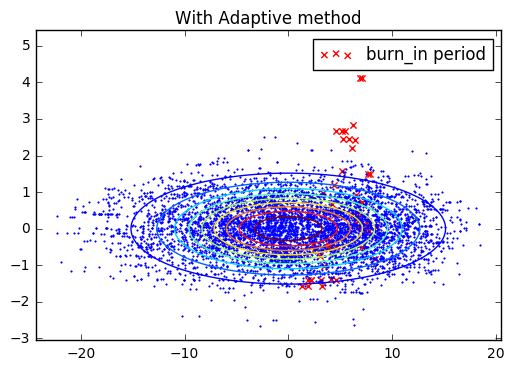

In [30]:
## With adaptation 
l,acc = ada_mh(x_0,y_0,a,bs,iter_,ada=True)
burn_in = 60 # Burn-in time 
p = plt.scatter(l[:burn_in,0], l[:burn_in,1], color='r',marker = 'x')
plt.scatter(l[burn_in:,0],l[burn_in:,1], color='b',s=1,lw=0.5)
plt.contour(X,Y,Z,levels); 
plt.legend([p],['burn_in period'])
plt.title('With Adaptive method')
print "Acceptance rate form kernel 1 : {0} times".format(acc[0])
print "Acceptance rate form kernel 2 : {0} times".format(acc[1])

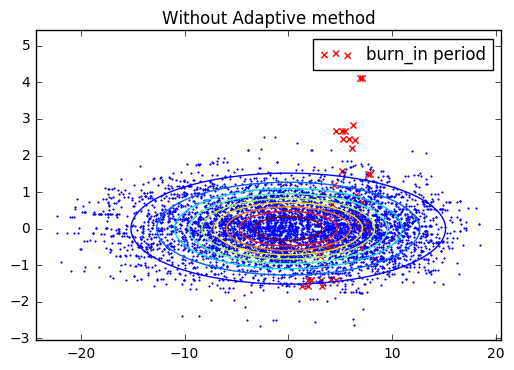

In [31]:
## without adaptation
l_woa,acc_woa = ada_mh(x_0,y_0,a,bs,iter_,ada=False)
burn_in = 60 # Burn-in time 
p = plt.scatter(l[:burn_in,0], l[:burn_in,1], color='r',marker = 'x')
plt.scatter(l[burn_in:,0],l[burn_in:,1], color='b',s=1,lw=0.5)
plt.contour(X,Y,Z,levels); 
plt.legend([p],['burn_in period'])
plt.title('Without Adaptive method')

In [32]:
print "Acceptance rate form kernel 1 : {0} times".format(acc_woa[0])
print "Acceptance rate form kernel 2 : {0} times".format(acc_woa[1])

Acceptance rate form kernel 1 : 0.956333333333 times
Acceptance rate form kernel 2 : 0.609666666667 times


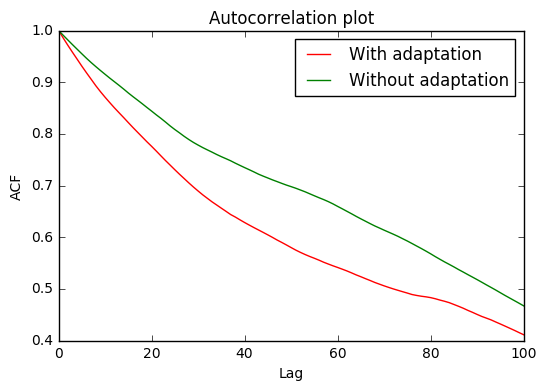

In [33]:
## Choose coordinate 
k = 0
pwith, = plt.plot(acf(l[:, k], nlags=100),'r')
pwithout, = plt.plot(acf(l_woa[:, k], nlags=100),'g')
plt.legend([pwith,pwithout],['With adaptation','Without adaptation'])
plt.title('Autocorrelation plot')
plt.xlabel('Lag')
plt.ylabel('ACF')

#### Conclusion: 
The acceptance rate is lower when we use the adaptive Metropolis-Hastings within Gibbs Sampler. Therefore it is better as here we have acceptance rate that are "anormaly" high.  We notice also an improvement of the Autocorrelation plot with the adaptive method for the first coordinate. The autocorrelation plot of the second coordinate are the same. 

#### Part 2: Adaptive MH sampler for target $\pi$, "banana"-shaped  density: 

$$ 
 f_B(x) \sim \exp \left( -\frac{x_1^2}{200} - \frac{1}{2} \left(x_2 + B x_1^2 - 100 B \right)^2 - \frac{1}{2} \left( x_3^2 + \ldots + x_d^2 \right) \right)
$$ 

In [34]:
def f_b(x,B): 
    ## Define the density function f_B of the Banana shape
    return np.exp(-np.power(x[0],2)/200 - 0.5*np.power(x[1]+B*np.power(x[0],2) - 100*B ,2) - 0.5 * np.sum(np.power(x[2:],2))  )

In [35]:
a = np.ones((5,1))

In [36]:
f_b([1,2,1,1,0.2],0.01)

0.079655037434455872

### Plot Banana shape in 2 dimensions:

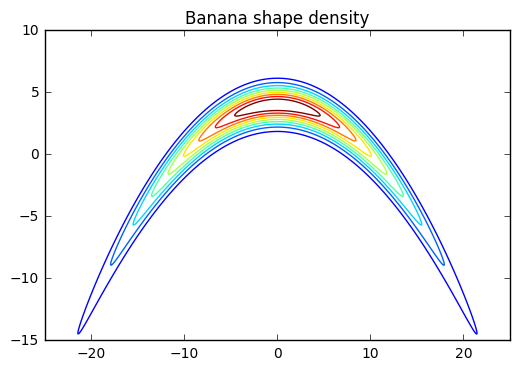

In [37]:
## Define the meshgrid 
xlist = np.linspace(-25,25,1000)
ylist = np.linspace(-15,10,1000)
X,Y = np.meshgrid(xlist, ylist)
## Define the levels 
B = 0.04
levels = np.arange(0,1,0.1)
Z = np.zeros((2,X.shape[0],X.shape[1])) 
Z[0,:,:] = X
Z[1,:,:] = Y
Z_banana = f_b(Z,B)
## Plot Target distribution 
plt.contour(X,Y,Z_banana,levels); 
plt.title('Banana shape density')

#### Sample by coordinate : 

In [194]:
def sample_coork(x,k,sigma_k,B): 
    ## Sample from coordinate k in 0..d-1 for the banana distribution 
    # rejection counter 
    c = 0 
    # Proposal :  
    eps = np.random.randn()
    x_ = np.copy(x)
    x_[k]  = x_[k] + sigma_k * eps 
    # Acceptance Ratio :
    alpha = np.min( [1, f_b(x_,B) / f_b(x,B) ]) 
    # Sample uniform 
    u = np.random.uniform(0,1)
    if alpha > u  : # We accept 
        return x_ ,c
    else : # We reject 
        c = 1 
        return x, c

### Define Metropolis-Hastings within Gibbs sampler for the banana shape

In [191]:
## Part 2, in d dimension for target with banana shape density in dimensions (1,2): 
def ada_mh_banana(x_0,y_0,d,B,bs,iter_, ada = True): 
    ## Assert we have at least dimension 2  
    assert d > 1
    x = np.ones((d,1))
    # define unit variance 
    l_ = np.zeros((d,1))
    # Initial point 
    x[0] = x_0
    x[1] = y_0
    ## l is a list to keep the first two coordinates 
    l =  [x_0,y_0]
    # acceptance rate
    acc = [0.0]*d
    ## Loop for batches
    for j in range(bs): 
        ## Loop for each batch
        for i in range(iter_):
            ## Perform Gibbs Sampling 
            # Update x_k and store the acceptance rate in acc for each coordinate : 
            for k in range(d): 
                x,c = sample_coork(x,k,np.exp(l_[k]),B)
                if c==0 : # if we accept x 
                    acc[k] += 1
            ## Keep first two coordinate 
            x_ = float(x[0])
            y_ = float(x[1])
            l = l + list([ x_ , y_ ])
        
        if ada : 
            # Compute acceptance rate when we finish each batch and update the variances 
            # Iterations up to now = (j+1)*iter_ 
            num_iter  = (j+1)*iter_ 
            for k in range(d):
                if acc[k] / ((j+1)*iter_) > acc_rate : 
                    l_[k] += delta(j+1)
                else:
                    l_[k] -= delta(j+1)
            if j % 5 == 0 : 
                print "Update After batch {0}".format(j)
        if not ada : 
            if j % 5 == 0 : 
                print "Batch {0}".format(j)
    for k in range(d): acc[k] /= bs*iter_
    ## Extract array of points from list  of the two first coordinates 
    num_point = len(l) /2 
    l = np.array(l)
    l = l.reshape((num_point,2))
    return l, acc 
        

In [202]:
## Define parameters: 
B = 0.04
bs = 50  # Batch iteration size
iter_ = 100 # Iteration within each batch 
acc_rate = 0.4
# Initial point 
x_0 = -15
y_0 = 10
## dimensions
d=20

Update After batch 0
Update After batch 5
Update After batch 10
Update After batch 15
Update After batch 20
Update After batch 25
Update After batch 30
Update After batch 35
Update After batch 40
Update After batch 45
Acceptance rate form coordinate 1 : 0.6488 times
Acceptance rate form coordinate 2 : 0.6488 times


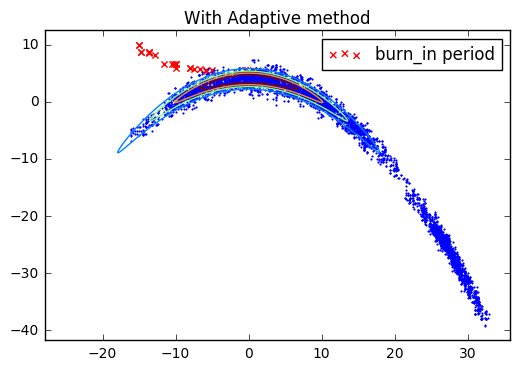

In [203]:
## With adaptation 
l,acc = ada_mh_banana(x_0,y_0,d,B,bs,iter_,ada=True)

## Plot the first two coordinate 
burn_in = 60 # Burn-in time 
p = plt.scatter(l[:burn_in,0], l[:burn_in,1], color='r',marker = 'x')
plt.scatter(l[burn_in:,0],l[burn_in:,1], color='b',s=1,lw=0.5)
levels=np.arange(0,1,0.2)
plt.contour(X,Y,Z_banana,levels); 
plt.legend([p],['burn_in period'])
plt.title('With Adaptive method')
print "Acceptance rate form coordinate 1 : {0} times".format(acc[0])
print "Acceptance rate form coordinate 2 : {0} times".format(acc[1])

Batch 0
Batch 5
Batch 10
Batch 15
Batch 20
Batch 25
Batch 30
Batch 35
Batch 40
Batch 45
Acceptance rate form coordinate 1 : 0.7666 times
Acceptance rate form coordinate 2 : 0.7006 times


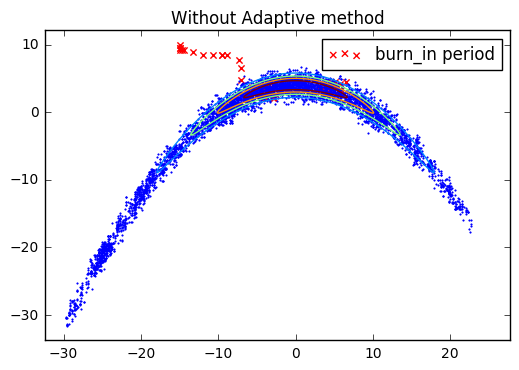

In [204]:
## Without adaptation 
l_woa,acc_woa = ada_mh_banana(x_0,y_0,d,B,bs,iter_,ada = False)

## Plot of the first two coordinate 
burn_in = 60 # Burn-in time 
p = plt.scatter(l_woa[:burn_in,0], l_woa[:burn_in,1], color='r',marker = 'x')
plt.scatter(l_woa[burn_in:,0],l_woa[burn_in:,1], color='b',s=1,lw=0.5)
levels=np.arange(0,1,0.2)
plt.contour(X,Y,Z_banana,levels); 
plt.legend([p],['burn_in period'])
plt.title('Without Adaptive method')
print "Acceptance rate form coordinate 1 : {0} times".format(acc_woa[0])
print "Acceptance rate form coordinate 2 : {0} times".format(acc_woa[1])

#### Conclusion 
We notice a decrease in the acceptance rate when we use adaptive method for the "banana"-shape density to a more reasonable rates. 

### Part 3: Multivariate centered gaussian distribution: 

Target is a d-dimendional Gaussian: 
$$ \mathcal{N} ( 0 , \Sigma ) $$

Read the text to store the covariance matrix. 

In [157]:
# store the variance matrix in sigma 
sigma = np.zeros([20,20])
path_to_cov = ''
f = open(path_to_cov + 'tmalaexcov.txt','r')
lines = f.readlines()
i=0 
for line in lines : 
    line = re.sub('\r\n', '', line)
    sigma[i,:] = np.array(line.split(' '),dtype=float)
    i += 1 

In [158]:
def pdfmn(x,sigma):
    # Return the probability density in x for a d-dimensional gaussian 
    return mn.pdf( x, cov=sigma)

In [104]:
def sample_coork_multi(x,k,sigma_k,S): 
    ## Sample from coordinate k in 0..d-1 for the multivariate gaussian distribution
    # rejection counter 
    c = 0 
    # Proposal :  
    eps = np.random.randn()
    x_ = np.copy(x)
    x_[k]  = x_[k] + sigma_k * eps 
    # Acceptance Ratio :
    alpha = np.min( [1, pdfmn(x_,S) / pdfmn(x,S) ]) 
    # Sample uniform 
    u = np.random.uniform(0,1)
    if alpha > u  : # We accept 
        return x_ ,c
    else : # We reject 
        c = 1 
        return x, c

In [105]:
## Part 3, in d dimension for target with multivariate gaussian density. 
def ada_mh_multi_gauss(x_init,d ,S, bs,iter_, ada = True): 
    ## Assert we have at least dimension 2  
    assert len(x_init) == d 
    # Initialize point
    x = np.array(x_init)
    # define unit variance 
    l_ = np.zeros((d,1))
    # P to store the point
    P = list(x)
    # acceptance rate
    acc = [0.0]*d
    ## Loop for batches
    for j in range(bs): 
        ## Loop for each batch
        for i in range(iter_):
            ## Perform Gibbs Sampling 
            # Update x_k and store the acceptance rate in acc for each coordinate : 
            for k in range(d): 
                x,c = sample_coork_multi(x,k,np.exp(l_[k]),S)
                if c==0 : # if we accept x 
                    acc[k] += 1
            P = P + list(x)
        
        if ada : 
            # Compute acceptance rate when we finish each batch and update the variances 
            # Iterations up to now = (j+1)*iter_ 
            num_iter  = (j+1)*iter_ 
            for k in range(d):
                if acc[k] / ((j+1)*iter_) > acc_rate : 
                    l_[k] += delta(j+1)
                else:
                    l_[k] -= delta(j+1)
            if j % 5 == 0 : 
                print "Update After batch {0}".format(j)
        if not ada : 
            if j % 5 == 0 : 
                print "Batch {0}".format(j)
    for k in range(d): acc[k] /= bs*iter_
    ## Extract array of points from list  of the two first coordinates 
    num_point = len(P) /d 
    P = np.array(P)
    P = P.reshape((num_point,d))
    return P, acc 
        

In [151]:
def plot_coor(i,j,P,acc): 
    assert i < 20 and j <20 and j != i ;  
    ## Plot two coordinates of your choice from the multivariate sample: 
    burn_in = 60 # Burn-in time 
    p = plt.scatter(P[:burn_in,i], P[:burn_in,j], color='r',marker = 'x')
    plt.scatter(P[burn_in:,i],P[burn_in:,j], color='b',s=1,lw=0.5)
    plt.legend([p],['burn_in period'])
    print "Acceptance rate form coordinate 1 : {0} times".format(acc[i])
    print "Acceptance rate form coordinate 2 : {0} times".format(acc[j])

In [148]:
# Define parameters : 
x_init = np.ones(20)
d = 20 
S = sigma 
bs = 50 
iter_ = 100

In [145]:
P,acc = ada_mh_multi_gauss(x_init,d ,S, bs,iter_, ada = True)

Update After batch 0
Update After batch 5
Update After batch 10
Update After batch 15
Update After batch 20
Update After batch 25
Update After batch 30
Update After batch 35
Update After batch 40
Update After batch 45


Acceptance rate form coordinate 1 : 0.4338 times
Acceptance rate form coordinate 2 : 0.4358 times


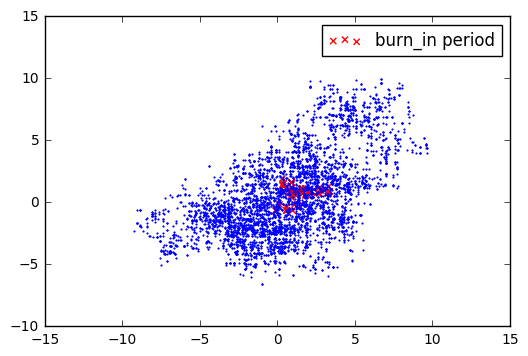

In [152]:
plot_coor(5,10,P,acc)

In [156]:
print "Mean Acceptance rate with adaptive method is {0}".format(np.mean(acc))

Mean Acceptance rate with adaptive method is 0.44928


In [146]:
P_woa,acc_woa = ada_mh_multi_gauss(x_init,d ,S, bs,iter_, ada = False)

Batch 0
Batch 5
Batch 10
Batch 15
Batch 20
Batch 25
Batch 30
Batch 35
Batch 40
Batch 45


Acceptance rate form coordinate 1 : 0.4538 times
Acceptance rate form coordinate 2 : 0.5054 times


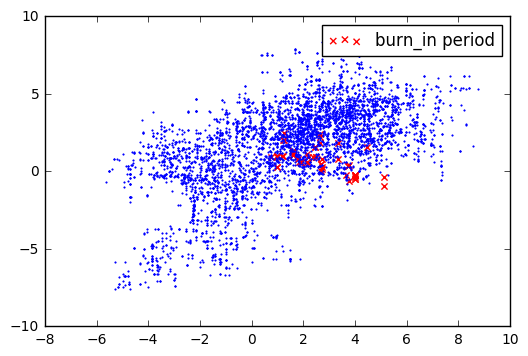

In [153]:
plot_coor(6,5,P_woa,acc_woa)

In [155]:
print "Mean Acceptance rate without adaptive method is {0}".format(np.mean(acc_woa))

Mean Acceptance rate without adaptive method is 0.48435


#### Conclusion 
The acceptance rate for the multivariate gaussian distribution in dimension $d=20$ is around $\textbf{0.48}$ without using adaptive method and $\textbf{0.44}$ when we use the adaptive method. Which is the goal of the adaptive method, as it attempts to make the acceptance rate of the proposals for variable $x_i$ as close as possible to $\textbf{0.44}$ 